In [30]:
# coding: UTF-8
import time
import torch
import numpy as np
import torch.utils.data as Data
from torch.utils.data import SubsetRandomSampler
import pandas as pd
import librosa
from train_eval import train, init_network
from importlib import import_module
import argparse

parser = argparse.ArgumentParser(description='Chinese Text Classification')
# parser.add_argument('pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113', type=str, required=True, help='choose a model: TextCNN, TextRNN, FastText, TextRCNN, TextRNN_Att, DPCNN, Transformer')
parser.add_argument('--embedding', default='pre_trained', type=str, help='random or pre_trained')
parser.add_argument('--word', default=False, type=bool, help='True for word, False for char')
args = parser.parse_args(args=[])

# Pytorch Python
class MyDataSet(Data.Dataset):

    def __init__(self, path_dir):
        dataset = np.load(path_dir, allow_pickle=True)
        self.x = dataset['x1'],dataset['x2']
        self.y = dataset['y']

    def __getitem__(self, index):
        return self.x[0][index],self.x[1][index],self.y[index]

    def __len__(self):
        return len(self.x[0])
data = MyDataSet("./Data/dataset.npz")
# 首先产生数据索引的乱序排列
shuffled_indices = np.random.permutation(len(data))
train_idx = shuffled_indices[:int(0.88 * len(data))]
val_idx = shuffled_indices[int(0.88 * len(data)):]
batch_size=50
# train_iter = Data.DataLoader(data, batch_size=batch_size,shuffle=False, drop_last=False, sampler=SubsetRandomSampler(train_idx))
train_iter = Data.DataLoader(data, batch_size=batch_size,shuffle=False, drop_last=False, sampler=train_idx)
dev_iter = Data.DataLoader(data, batch_size=batch_size, shuffle=False,drop_last=False, sampler=val_idx)
test_iter = Data.DataLoader(data, batch_size=batch_size, shuffle=False,drop_last=False, sampler=val_idx)

In [ ]:
label=pd.read_table('Data/TAL-SER/label/label',sep=' ')
data_info.columns=['id','path']
data_info=pd.merge(label,data_info,on='id')

In [2]:
from pandarallel import pandarallel
import warnings
warnings.filterwarnings("ignore")
pandarallel.initialize(nb_workers=100)
data_info=pd.read_table('Data/TAL-SER/label/wav.scp',header=None,sep=' ')
label=pd.read_table('Data/TAL-SER/label/label',sep=' ')
data_info.columns=['id','path']
data_info=pd.merge(label,data_info,on='id')


def get_waveform(x):
    try:
        # np.append(temp,np.array([[x.P]*1600]), axis = 0)
        temp = librosa.load(x.path.replace('./','Data/TAL-SER/'), sr=16000)[0][:160000].reshape(100,1600)
        mu = np.mean(temp, axis=0)
        sigma = np.std(temp, axis=0)
        return (temp - mu) / sigma
    except:
        return None
def get_spectrogram(x):
    try:
        temp = librosa.amplitude_to_db(librosa.stft(x.wave_matrix.flatten())).reshape(1025, 313)
        mu = np.mean(temp, axis=0)
        sigma = np.std(temp, axis=0)
        return (temp - mu) / sigma
    except:
        return None
data_info['wave_matrix']=data_info.parallel_apply(lambda x:get_waveform(x),axis=1) # 100 , 1600
data_info=data_info[data_info['wave_matrix'].notnull()]
data_info['spect_matrix']=data_info.parallel_apply(lambda x:get_spectrogram(x),axis=1) #(1025, 313)
data_info=data_info[data_info['spect_matrix'].notnull()]
data_info
## 划分训练集和测试集
##CCC

INFO: Pandarallel will run on 100 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


,id,P,A,path,wave_matrix,spect_matrix
0,2,0.861101,-0.461314,./SER0027/2.wav,"[[-0.045908473, -0.023430632, -0.029332533, -0...","[[0.846828, 0.70998913, 0.32966557, 0.43620148..."
1,3,0.861101,-0.561349,./SER0017/3.wav,"[[0.35816914, 0.08520981, -0.1928027, -0.40735...","[[1.5911081, 1.2275333, 0.9805421, 0.87911546,..."
2,4,0.342678,-0.561349,./SER0016/4.wav,"[[0.030468684, 0.09418485, 0.15401627, 0.17972...","[[1.0566698, -0.9670911, -0.08325844, -0.30755..."
3,5,1.897946,0.739109,./SER008/5.wav,"[[-1.9690386, -1.8408918, -1.3986933, -1.77658...","[[0.66650677, 0.10306606, 0.34619477, 1.214750..."
4,6,0.472284,0.338968,./SER0028/6.wav,"[[1.3688928, 1.0275813, 0.40445426, 0.0897042,...","[[0.5463149, 0.7614755, 0.89058644, 0.24110408..."
...,...,...,...,...,...,...
4183,6844,0.342678,1.039214,./SER0030/6844.wav,"[[-0.1525222, -0.22955598, -0.21740592, -0.234...","[[0.6282856, 0.9224188, 1.1338761, 0.37316534,..."
4184,6846,-0.564561,0.539038,./SER006/6846.wav,"[[-0.08288644, -0.0807526, 0.23284158, 0.08088...","[[0.7394998, -0.7225677, -0.38410616, 0.507807..."
4185,6848,0.990706,0.238933,./SER0034/6848.wav,"[[1.3700272, 1.2443044, 0.8209484, 0.21402872,...","[[1.3567164, 0.6238397, 0.37964833, 0.2678839,..."
4186,6849,0.342678,0.739109,./SER0031/6849.wav,"[[0.31895775, -0.17045186, -1.3294709, -2.0480...","[[0.22181682, 0.48390466, -0.3721028, 0.472760..."


In [ ]:
4813 ->model ->predict

In [ ]:
predict== groundtruth

In [3]:
# 标准化
def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma
x1=np.array([list(x) for x in data_info['wave_matrix']])
x2=np.array([list(x) for x in data_info['spect_matrix']])
y=standardization(data_info.A.values)
np.savez('./Data/dataset.npz',x1=x1,x2=x2,y=y)

In [1]:
def ccc(x,y):
    ''' Concordance Correlation Coefficient'''
    sxy = np.sum((x - x.mean())*(y - y.mean()))/x.shape[0]
    rhoc = 2*sxy / (np.var(x) + np.var(y) + (x.mean() - y.mean())**2)
    return rhoc

In [6]:
import numpy as np
X = np.array([0,1,0])
Y = np.array([0,1,0])

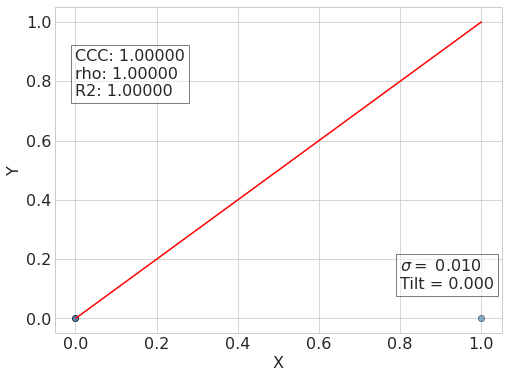

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from numpy.random import default_rng
def ccc(x,y):
    ''' Concordance Correlation Coefficient'''
    sxy = np.sum((x - x.mean())*(y - y.mean()))/x.shape[0]
    rhoc = 2*sxy / (np.var(x) + np.var(y) + (x.mean() - y.mean())**2)
    return rhoc
def r(x,y):
    ''' Pearson Correlation Coefficient'''
    sxy = np.sum((x - x.mean())*(y - y.mean()))/x.shape[0]
    rho = sxy / (np.std(x)*np.std(y))
    return rho
with plt.style.context(('seaborn-whitegrid')):
    plt.figure(figsize=(8,6))
    
    # Scatter plot of X vs Y
    plt.scatter(X,Y,edgecolors='k',alpha=0.5)
 
    # Plot of the 45 degree line
    plt.plot([0,1],[0,1],'r')
    
    rng = default_rng()
    sigma = 0.01
    tilt = 0
    for i in range(X.shape[0]):
        Y[i] = tilt*(X[i]-0.5) + rng.normal(X[i],sigma)

    plt.text(0, 0.75*Y.max(), "CCC: %5.5f"%(ccc(X,Y))+"\nrho: %5.5f"%(r(X,Y))+"\nR2: %5.5f"%(r2_score(X, Y)),\
             fontsize=16, bbox=dict(facecolor='white', alpha=0.5))
    plt.text(0.8, 0.1, "$\sigma=$ %5.3f"%(sigma)+"\nTilt = %5.3f"%(tilt),\
             fontsize=16, bbox=dict(facecolor='white', alpha=0.5))
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('X',fontsize=16)
    plt.ylabel('Y',fontsize=16)
    
    plt.show()